<!--NOTEBOOK_HEADER-->
*This notebook contains material from [cbe30338-2021](https://jckantor.github.io/cbe30338-2021);
content is available [on Github](https://github.com/jckantor/cbe30338-2021.git).*


<!--NAVIGATION-->
< [6.3  Predictive Control](https://jckantor.github.io/cbe30338-2021/06.03-Predictive-Control.html) | [Contents](toc.html) | [Tag Index](tag_index.html) | [7.0 Projects](https://jckantor.github.io/cbe30338-2021/07.00-Projects.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/06.04-Implementing-Predictive-Control.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/06.04-Implementing-Predictive-Control.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# Lab Assignment 9

## Austin Booth, adapted from Notebook 6.4

Link:


# 6.4  Implementing Predictive Control

The goal of this notebook is to demonstrate an implementation of predictive control.

## 6.4.1 Model

Once agaiin will use the two-state model for a single heater/sensor assembly to demonstrate the key elements of this notebook.

\begin{align}
C^H_p\frac{dT_{H,1}}{dt} & = U_a(T_{amb} - T_{H,1}) + U_b(T_{S,1} - T_{H,1}) + \alpha P_1 u_1\\
C^S_p\frac{dT_{S,1}}{dt} & = U_b(T_{H,1} - T_{S,1}) 
\end{align}

The model is recast into linear state space form as

\begin{align}
\frac{dx}{dt} & = A x + B_u u + B_d d \\
y & = C x
\end{align}

where

$$x = \begin{bmatrix} T_{H,1} \\ T_{S,1} \end{bmatrix}
\qquad
u = \begin{bmatrix} u_1 \end{bmatrix}
\qquad
d = \begin{bmatrix} T_{amb} \end{bmatrix}
\qquad
y = \begin{bmatrix} T_{S,1} \end{bmatrix}$$

and

$$A = \begin{bmatrix} -\frac{U_a+U_b}{C^H_p} & \frac{U_b}{C^H_p} \\ \frac{U_b}{C^S_p} & -\frac{U_b}{C^S_p} \end{bmatrix}
\qquad
B_u = \begin{bmatrix} \frac{\alpha P_1}{C^H_p} \\ 0 \end{bmatrix}
\qquad
B_d = \begin{bmatrix} \frac{U_a}{C_p^H} \\ 0 \end{bmatrix}
\qquad
C = \begin{bmatrix} 0 & 1 \end{bmatrix}$$

The following cell creates values for the model parameters.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp

# parameter estimates.
alpha = 0.00016       # watts / (units P * percent U1)
P1 = 200              # P units
P2 = 100              # P units
Ua = 0.050            # heat transfer coefficient from heater to environment
CpH = 2.2             # heat capacity of the heater (J/deg C)
CpS = 1.9             # heat capacity of the sensor (J/deg C)
Ub = 0.021            # heat transfer coefficient from heater to sensor

# state space model
A = np.array([[-(Ua + Ub)/CpH, Ub/CpH], [Ub/CpS, -Ub/CpS]])
Bu = np.array([[alpha*P1/CpH], [0]])     # single column
Bd = np.array([[Ua/CpH], [0]])           # single column
C = np.array([[0, 1]])                   # single row

## 6.4.2 Control Objective

An optimal control policy minimizes the differences

\begin{align*}
\min_{u} \int_{t_0}^{t_f} \|T_S(t) - SP(t)\|^2\,dt \\
\end{align*}

where $SP(t)$ is a setpoint, subject to constraints

\begin{align*}
C_p^H \frac{dT_H}{dt} & = U_a (T_{amb}(t) - T_H) + U_c (T_S - T_H) + P u(t)\\
C_p^S \frac{dT_S}{dt} & = - U_c (T_S - T_H) 
\end{align*}

initial conditions

\begin{align*}
T_H(t_0) & = T_{amb}(0) \\
T_S(t_0) & = T_{amb}(0)
\end{align*}

where $T_{amb}(t)$ is a possibly time-varying disturbance.

In [2]:
# estimates of future behavior
Tamb = 20
SP = 45

## 6.4.3 Assumptions Need to Use Optimization for Real-Time Feedback

Predictive control is a strategy that uses optimization for feedback control. The basic concept is to solve an optimization problem at every time step utilizing all of the information available up to that point in time. **The key assumptions** are:

1. The current value of the setpoint will be held constant into the future.
2. The current estimate of any disturbances will be constant into the future.
3. The state at the current time is available from a state estimator.

Assumptions 1 and 2 are obviously very strong statements about the future. But in the absence of additional information, these assumptions are about the best we can expect. 


## 6.4.4 Bare Bones Event Loop

Borrowing from notebook 4.6, we start the process of implementing predictive control by starting with an implementation of a simpler strategy (relay control) that includes a state observer. With that framework in place, we will show what modifications are need to implement predictive control. 

*Note: This code has been cut and pasted from earlier notebooks, but with some edits for brevity and clarity.*

### 6.4.4.1 Relay Control

The relay controller is an instance of a Python generator that is sent values of the setpoint and process variable, and yields values for a manipulated variable. Each instance of the relay controller is initialized with minimum and maximum values of the manipulated variable. Later we will be replacing the relay control with a predictive control.

In [3]:
# Relay Control
def relay(MV_min, MV_max):
    MV = MV_min
    while True:
        # yield manipulated variable. Wait for message from the
        # event with updated setpoint and process variable measurement.
        SP, PV = yield MV
        MV = MV_min if PV >= SP else MV_max

### 6.4.4.2 Observer

Given current values of the manipulated input, the sensor measurement, and estimated disturbance sent from the event loop, the observer updates the state estimate 

In [4]:
def tclab_observer(L, t_prev=0, x=[Tamb, Tamb], d=[Tamb]):
    while True:
        # yield current state estimate. Wait for message information
        # needed to update the state estimate for the next time step
        t, U, T_sensor, Tamb = yield x
        
        # prediction
        x = x + (t - t_prev)*(A@x + Bu@[U] + Bd@[Tamb])
        
        # correction
        x = x - (t - t_prev)*L@(C@x - np.array([T_sensor]))
        t_prev = t

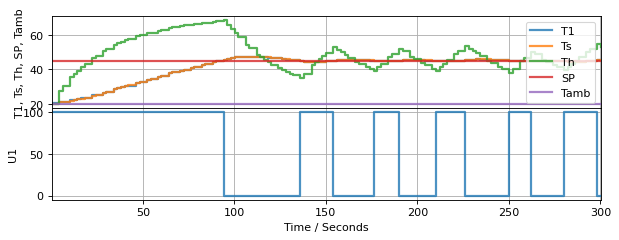

TCLab Model disconnected successfully.


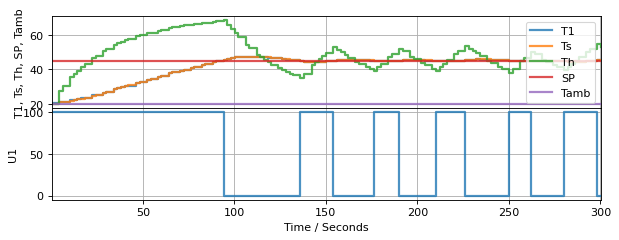

In [5]:
from tclab import setup, clock, Historian, Plotter

t_final = 300
t_step = 2

# create and initialize a controller instance
controller = relay(0, 100)
U1 = next(controller)

# create and initialize an observer instance
L = np.array([[0.4], [0.2]])
observer = tclab_observer(L)
Th, Ts = next(observer)

# execute the event loop
TCLab = setup(connected=False, speedup=10)
with TCLab() as lab:
    h = Historian([('SP', lambda: SP), 
                   ('T1', lambda: T1), 
                   ('U1', lambda: U1), 
                   ('Th', lambda: Th), 
                   ('Ts', lambda: Ts),
                   ('Tamb', lambda: Tamb)])
    p = Plotter(h, t_final, layout=[['T1','Ts','Th', 'SP', 'Tamb'], ['U1']])
    for t in clock(t_final, t_step):
        T1 = lab.T1 
        Th, Ts = observer.send([t, U1, T1, Tamb])
        U1 = controller.send([SP, Ts])
        lab.Q1(U1)
        p.update(t)

## 6.4.5 Feedforward Optimization

As a preliminary step, we first create a CVXPY model that that computes a feedforward control policy given values for the setpoint $SP$, disturbance $T_{amb}$, and the current state. This code was cut-and-pasted from a previous notebook, with modifications to use the values `SP` and `Tamb` defined in this notebook.

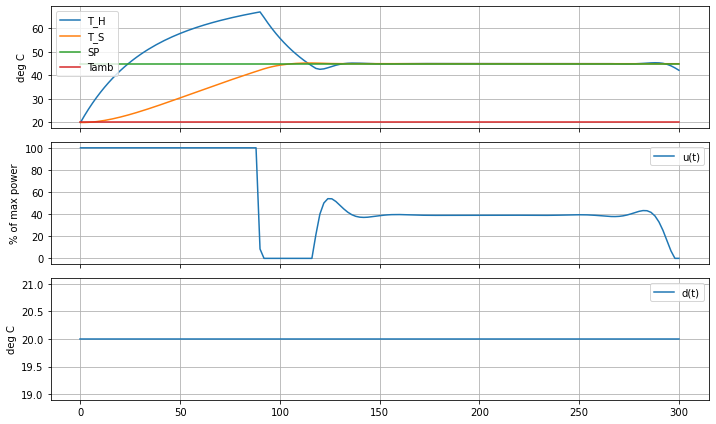

In [6]:
t_horizon = 300
dt = 2
n = round(t_horizon/dt)
t_grid = np.linspace(0, t_horizon, n+1)

# add $u$ as a decision variable
u = {t: cp.Variable(1, nonneg=True) for t in t_grid}
x = {t: cp.Variable(2) for t in t_grid}
y = {t: cp.Variable(1) for t in t_grid}

# least-squares optimization objective
objective = cp.Minimize(sum((SP - y[t])**2 for t in t_grid))

model = [x[t] == x[t-dt] + dt*(A@x[t-dt] + Bu@u[t-dt] + Bd@[Tamb]) for t in t_grid[1:]]
output = [y[t] == C@x[t] for t in t_grid]
inputs = [u[t] <= 100 for t in t_grid]
IC = [x[0] == np.array([Tamb, Tamb])]

problem = cp.Problem(objective,  model + IC + output + inputs)
problem.solve()

# display solution
fix, ax = plt.subplots(3, 1, figsize=(10,6), sharex=True)
ax[0].plot(t_grid, [x[t][0].value  for t in t_grid], label="T_H")
ax[0].plot(t_grid, [x[t][1].value  for t in t_grid], label="T_S")
ax[0].plot(t_grid, [SP for t in t_grid], label="SP")
ax[0].plot(t_grid, [Tamb for t in t_grid], label="Tamb")
ax[0].set_ylabel("deg C")
ax[0].legend()
ax[1].plot(t_grid, [u[t].value for t in t_grid], label="u(t)")
ax[1].set_ylabel("% of max power")
ax[2].plot(t_grid, [Tamb for t in t_grid], label="d(t)")
ax[2].set_ylabel("deg C")
for a in ax:
    a.grid(True)
    a.legend()
plt.tight_layout()

### 6.4.5.1 A Predictive Controller

The next step is to encapsulate the feedforward control computation into a generator that can be run from the event loop each time new information becomes available.

The `warm_start` option tells CVXPY to use results from the prior soluton to update the current solution. Not every solver offers this feature, but when they do it can often lead to a signficant speedup of the computations.

In [7]:
def predictive_control(t_horizon=300, dt=2):
    # create time grid
    n = round(t_horizon/dt)
    t_grid = np.linspace(0, t_horizon, n+1)
    
    # create decision variables and all parts of the model
    # that do not depend on information from the event loop
    u = {t: cp.Variable(1, nonneg=True) for t in t_grid}
    x = {t: cp.Variable(2) for t in t_grid}
    y = {t: cp.Variable(1) for t in t_grid}
    output = [y[t] == C@x[t] for t in t_grid]
    inputs = [u[t] <= 100 for t in t_grid]

    MV = 0
    while True:
        # yield MV, then wait for new information to update MV
        SP, Th, Ts, Tamb = yield MV
        objective = cp.Minimize(sum((y[t]-SP)**2 for t in t_grid))
        model = [x[t] == x[t-dt] + dt*(A@x[t-dt] + Bu@u[t-dt] + Bd@[Tamb]) for t in t_grid[1:]]
        IC = [x[0] == np.array([Th, Ts])]
        problem = cp.Problem(objective,  model + IC + output + inputs)
        problem.solve(warm_start=True)
        MV = u[0].value[0]

## 6.4.6 Testing the Predictive Controller

Let's put the predictive controller to work. Note that the speedup factor the simulation has been changed. This is needed to accomodate the far more intensive calculations that are taking place at each time step.

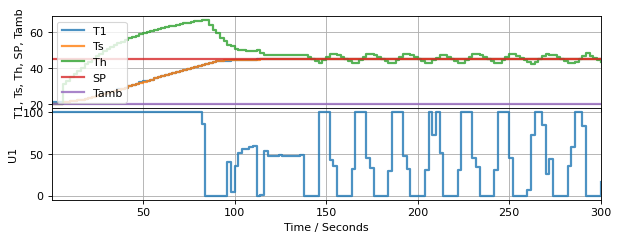

TCLab Model disconnected successfully.


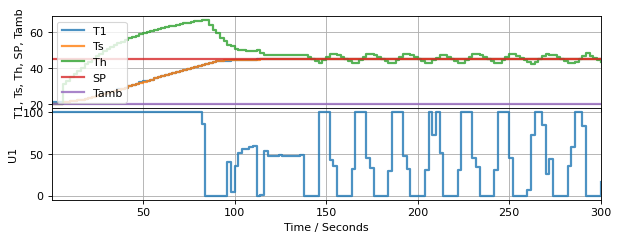

In [8]:
t_final = 300
t_step = 2

# create a controller instance
controller = predictive_control(dt=t_step)
U1 = next(controller)

# create estimator instance
L = np.array([[0.4], [0.2]])
observer = tclab_observer(L)
Th, Ts = next(observer)

# execute the event loop
TCLab = setup(connected=False, speedup=5)
with TCLab() as lab:
    h = Historian([('SP', lambda: SP), 
                   ('T1', lambda: T1), 
                   ('U1', lambda: U1), 
                   ('Th', lambda: Th), 
                   ('Ts', lambda: Ts),
                   ('Tamb', lambda: Tamb)])
    p = Plotter(h, t_final, layout=[['T1','Ts','Th', 'SP', 'Tamb'], ['U1']])
    for t in clock(t_final, t_step):
        T1 = lab.T1 
        Th, Ts = observer.send([t, U1, T1, Tamb])
        U1 = controller.send([SP, Th, Ts, Tamb])
        lab.Q1(U1)
        p.update(t)

<hr>

**Study Question:** Compare the closed-loop response of the simulation where the control policy is continually updated to the previous feedforward control calculation. List a few ways they are the similar?  List a few ways they are different.

<hr>

## 6.4.7 Lab Assignment 9

### 6.4.7.1 Exercise 1. Improving the Predictive Controller

While we appear to have a working controller, there are some problems revealed by the simulation that need to be fixed before attempting to to use this on real hardware. The major issues are:

* The controller is sensitive to minor modeling errors. The control action makes large changes in response to small measurement errors which would not be a good thing for real hardware.

* There is little guidance on how to choose the time horizon and time step for the predictive control calculations.

* The predictive control calculations are slow. 

Let's consider the first of these issues. The predictive control given above minimizes the following objective:

$$\min \sum_{k=0}^n (y(t_k) - SP)^2$$

This objective includes no mention of the control variable $u$ which means the optimizer can call for large changes in $u$ with no penalty. This can be modified.

$$\min \left[ (1-\alpha)\sum_{k=0}^n (y(t_k) - SP)^2 + \alpha \sum_{k=1}^n (u(t_k) - u(t_{k-1})^2 \right]$$

where $0 \leq \alpha \leq 1$ tells us how much weight to put on each objective. When $\alpha=0$ the only goal is to keep the setpoint error small. When $\alpha=1$ the only goal is to minimize changes in the manipulable input.  Clearly we want to find a compromise between these two competing goals.

In the cells below, copy and paste the code for the predictive control and the closed-loop simulation for the two state model. Name the new control generator `my_predictive_control`. Make the following modifications:

1. Implement the modified objective described above. Include `alpha` as a named parameter in the control generator with a default value of 0. Verify that you can reproduce the results given above for $alpha=0$. Then test for values of $alpha$ equal to 0.01, 0.1, and 0.5. Based on your engineering judgemet, which value would you choose for use on your hardware? Why? 
2. To speed up the control computations, modify the predictive controller to use larger time steps in the calculation (for this step, don't change the time step in the event loop, just the time step in the controller). Try values of 5 and 10 seconds. What do you observe? Again, using your engineering judgement, choose a value to implement on your hardware.
3. Next, change the value of the time step in the event loop.  Start by doubling to 4 seconds. Keep doubling. Pick a time step for the event loop for hardware use that doesn't overly compromise control performance.

For your assignment, you only need to show the final simulation result of these tuning procedures.

In [31]:
def my_predictive_control(t_horizon=300, dt=2, alpha=0):
    # create time grid
    n = round(t_horizon/dt)
    t_grid = np.linspace(0, t_horizon, n+1)
    
    # create decision variables and all parts of the model
    # that do not depend on information from the event loop
    u = {t: cp.Variable(1, nonneg=True) for t in t_grid}
    x = {t: cp.Variable(2) for t in t_grid}
    y = {t: cp.Variable(1) for t in t_grid}
    output = [y[t] == C@x[t] for t in t_grid]
    inputs = [u[t] <= 100 for t in t_grid]

    MV = 0
    while True:
        # yield MV, then wait for new information to update MV
        SP, Th, Ts, Tamb = yield MV
        objective = cp.Minimize((1-alpha)*sum((y[t]-SP)**2 for t in t_grid) +
                                alpha*sum((u[t]-u[t-dt])**2 for t in t_grid[1:]))
        model = [x[t] == x[t-dt] + dt*(A@x[t-dt] + Bu@u[t-dt] + Bd@[Tamb]) for t in t_grid[1:]]
        IC = [x[0] == np.array([Th, Ts])]
        problem = cp.Problem(objective,  model + IC + output + inputs)
        problem.solve(warm_start=True)
        MV = u[0].value[0]

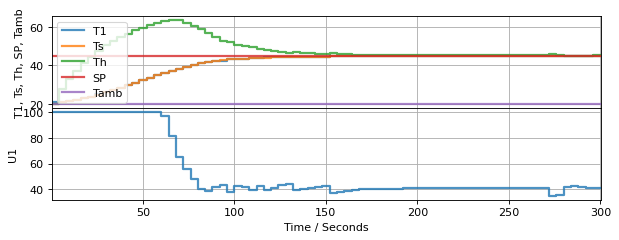

TCLab Model disconnected successfully.


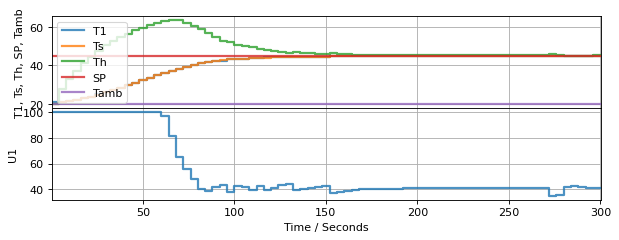

In [36]:
t_final = 300
t_step = 4         # for event loop
control_step = 5   # for controller
alpha_set = 0.01

# create a controller instance
controller = my_predictive_control(dt=control_step, alpha=alpha_set)
U1 = next(controller)

# create estimator instance
L = np.array([[0.4], [0.2]])
observer = tclab_observer(L)
Th, Ts = next(observer)

# execute the event loop
TCLab = setup(connected=False, speedup=5)
with TCLab() as lab:
    h = Historian([('SP', lambda: SP), 
                   ('T1', lambda: T1), 
                   ('U1', lambda: U1), 
                   ('Th', lambda: Th), 
                   ('Ts', lambda: Ts),
                   ('Tamb', lambda: Tamb)])
    p = Plotter(h, t_final, layout=[['T1','Ts','Th', 'SP', 'Tamb'], ['U1']])
    for t in clock(t_final, t_step):
        T1 = lab.T1 
        Th, Ts = observer.send([t, U1, T1, Tamb])
        U1 = controller.send([SP, Th, Ts, Tamb])
        lab.Q1(U1)
        p.update(t)

1. Using alpha = 0 did create the same (or very similar) response as above. I would select alpha = 0.01 for future use because it still tracks the set point very closely and has U1 values that do not fluctuate rapidly but do gradually change to sensitively track the set point. However, the U1 values are not as "flat" and the control is more responsive compared to higher alpha values. 0.01 is probably a sufficient alpha value because of the high possible values of U (0-100).

2. A control time step of 5 seconds allows for somewhat less fluctuation in U1, and avoids overreaction while retaining sensitive tracking of the set point. 10 seconds has less sensitive control where Ts does not reach the set point as quickly. I will choose 5 seconds.

3. An event loop time step of 8 seconds introduces a little too much deviation in U1 and Th for my liking; I will stick to 4 seconds for the event loop.

### 6.4.7.2 Exercise 2. Predictive control of the four state model.

Using the results of the first exercise, now modify the your code to accomodate the complete four state model of the TCLab hardware. 

1. Targeting setpoints of 45 and 35 degrees for the sensor temperatures, test your results in simulation.
2. Modify the code to control the heater temperatures to those same setpoints. Do you need to modify your controller tuning?

For this exercise, you only need to show the final simulation result.


### Note: for this part I will be using the estimated parameters and the L matrix from the simulated device from Lab Assignment 6, and not the calculated parameters for my device. I will enter my device's parameters in Exercise 3.

In [117]:
# parameter estimates for simulator
alpha = 0.00016       # watts / (units P * percent U1)
P1 = 200              # P units
P2 = 100              # P units
CpH = 4.46            # heat capacity of the heater (J/deg C)
CpS = 0.819           # heat capacity of the sensor (J/deg C)
Ua = 0.050            # heat transfer coefficient from heater to environment
Ub = 0.021            # heat transfer coefficient from heater to sensor
Uc = 0.0335           # heat transfer coefficient between heaters
Tamb = 21             # ambient room temperature

# state space model
A = np.array([[-(Ua + Ub + Uc)/CpH, Ub/CpH, Uc/CpH, 0], 
              [Ub/CpS, -Ub/CpS, 0, 0],
              [Uc/CpH, 0, -(Ua + Ub + Uc)/CpH, Ub/CpH],
              [0, 0, Ub/CpS, -Ub/CpS]])

Bu = np.array([[alpha*P1/CpH, 0], [0, 0], [0, alpha*P2/CpH], [0, 0]])

Bd = np.array([[Ua/CpH], [0], [Ua/CpH], [0]])

C = np.array([[0, 1, 0, 0], [0, 0, 0, 1]])

# initial values for states and inputs
d_initial = np.array([Tamb])
x_initial = np.array([Tamb, Tamb, Tamb, Tamb])

In [118]:
# set up L matrix
from scipy.signal import place_poles

evals, _ = np.linalg.eig(A)

results = place_poles(A.T, C.T, 3*evals)
L = results.gain_matrix.T

print(L)

[[ 0.05695624 -0.01773553]
 [ 0.0990523  -0.01497065]
 [-0.01744486  0.05443456]
 [-0.01502702  0.09723378]]


In [122]:
# set up 4-state observer
def tclab_observer(L, t_prev=0, x=[Tamb, Tamb, Tamb, Tamb], d=[Tamb]):
    while True:
        # yield current state estimate. Wait for message information
        # needed to update the state estimate for the next time step
        t, U, T_sensor, Tamb = yield x  # these should now be multivariable arrays
        
        # prediction
        x = x + (t - t_prev)*(A@x + Bu@U + Bd@[Tamb])
        
        # correction
        x = x - (t - t_prev)*L@(C@x - T_sensor)
        t_prev = t

In [130]:
# create controller
def my_predictive_control(t_horizon=300, dt=2, alpha=0):
    # create time grid
    n = round(t_horizon/dt)
    t_grid = np.linspace(0, t_horizon, n+1)
    
    # create decision variables and all parts of the model
    # that do not depend on information from the event loop
    u = {t: cp.Variable(2, nonneg=True) for t in t_grid}
    x = {t: cp.Variable(4) for t in t_grid}
    y = {t: cp.Variable(2) for t in t_grid}
    output = [y[t] == C@x[t] for t in t_grid]
    input1 = [u[t][0] <= 100 for t in t_grid]
    input2 = [u[t][1] <= 100 for t in t_grid]

    MV = [0, 0]
    while True:
        # yield MV, then wait for new information to update MV
        SP, Th, Ts, Tamb = yield MV   # these should now be multivariable arrays
        objective1 = cp.Minimize((1-alpha)*sum((y[t][0]-SP[0])**2 for t in t_grid) +
                                alpha*sum((u[t][0]-u[t-dt][0])**2 for t in t_grid[1:]))
        objective2 = cp.Minimize((1-alpha)*sum((y[t][1]-SP[1])**2 for t in t_grid) +
                                alpha*sum((u[t][1]-u[t-dt][1])**2 for t in t_grid[1:]))
        model = [x[t] == x[t-dt] + dt*(A@x[t-dt] + Bu@u[t-dt] + Bd@[Tamb]) for t in t_grid[1:]]
        IC = [x[0] == [Th[0], Ts[0], Th[1], Ts[1]]]
        problem = cp.Problem(objective1 + objective2,  model + IC + output + input1 + input2)
        problem.solve(warm_start=True)
        MV = [u[0].value[0], u[0].value[1]]

### Setting Sensed Temperatures to Set Points

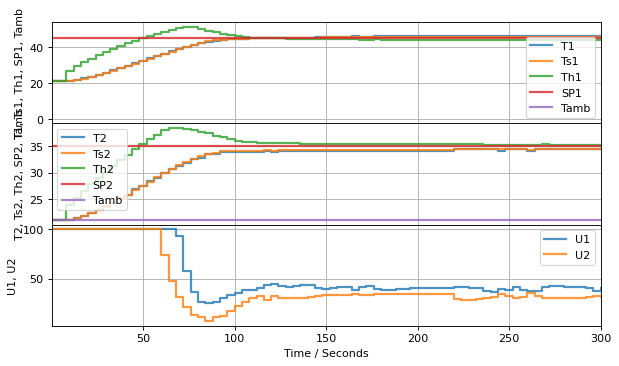

TCLab Model disconnected successfully.


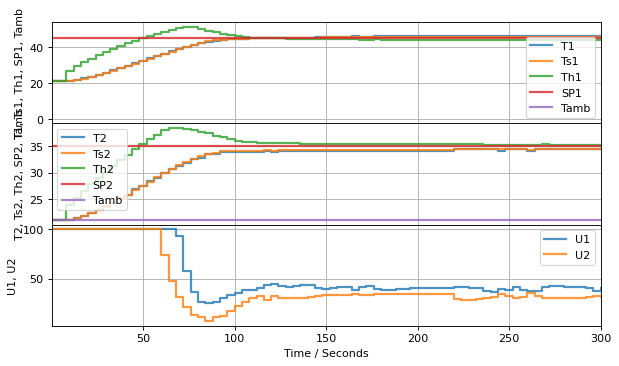

In [136]:
t_final = 300
t_step = 4         # for event loop
control_step = 5   # for controller
alpha_set = 0.001  # changed to give more sensitive results
SP1 = 45
SP2 = 35

# create a controller instance
controller = my_predictive_control(dt=control_step, alpha=alpha_set)
U1, U2 = next(controller)

# create estimator instance
observer = tclab_observer(L)
Th1, Ts1, Th2, Ts2 = next(observer)

# execute the event loop
TCLab = setup(connected=False, speedup=5)
with TCLab() as lab:
    h = Historian([('SP1', lambda: SP1), 
                   ('SP2', lambda: SP2), 
                   ('T1', lambda: T1), 
                   ('U1', lambda: U1), 
                   ('T2', lambda: T2), 
                   ('U2', lambda: U2), 
                   ('Th1', lambda: Th1), 
                   ('Ts1', lambda: Ts1),
                   ('Th2', lambda: Th2), 
                   ('Ts2', lambda: Ts2),
                   ('Tamb', lambda: Tamb)])
    p = Plotter(h, t_final, layout=[['T1','Ts1','Th1', 'SP1', 'Tamb'], ['T2','Ts2','Th2', 'SP2', 'Tamb'], ['U1','U2']])
    for t in clock(t_final, t_step):
        T1 = lab.T1 
        T2 = lab.T2
        
        # run observer to get Th and Ts
        Th1, Ts1, Th2, Ts2 = observer.send([t, [U1,U2], [T1,T2], Tamb])
        Th = [Th1,Th2]
        Ts = [Ts1,Ts2]
        
        U1, U2 = controller.send([[SP1,SP2], Th, Ts, Tamb])
        
        lab.Q1(U1)
        lab.Q2(U2)
        p.update(t)

### Setting Heater Temperatures to Set Points

In [137]:
# create controller
def my_predictive_control(t_horizon=300, dt=2, alpha=0):
    # create time grid
    n = round(t_horizon/dt)
    t_grid = np.linspace(0, t_horizon, n+1)
    
    # create decision variables and all parts of the model
    # that do not depend on information from the event loop
    u = {t: cp.Variable(2, nonneg=True) for t in t_grid}
    x = {t: cp.Variable(4) for t in t_grid}
    y = {t: cp.Variable(2) for t in t_grid}
    output = [y[t] == C@x[t] for t in t_grid]
    input1 = [u[t][0] <= 100 for t in t_grid]
    input2 = [u[t][1] <= 100 for t in t_grid]

    MV = [0, 0]
    while True:
        # yield MV, then wait for new information to update MV
        SP, Th, Ts, Tamb = yield MV   # these should now be multivariable arrays
        objective1 = cp.Minimize((1-alpha)*sum((x[t][0]-SP[0])**2 for t in t_grid) +
                                alpha*sum((u[t][0]-u[t-dt][0])**2 for t in t_grid[1:]))
        objective2 = cp.Minimize((1-alpha)*sum((x[t][2]-SP[1])**2 for t in t_grid) +
                                alpha*sum((u[t][1]-u[t-dt][1])**2 for t in t_grid[1:]))
        model = [x[t] == x[t-dt] + dt*(A@x[t-dt] + Bu@u[t-dt] + Bd@[Tamb]) for t in t_grid[1:]]
        IC = [x[0] == [Th[0], Ts[0], Th[1], Ts[1]]]
        problem = cp.Problem(objective1 + objective2,  model + IC + output + input1 + input2)
        problem.solve(warm_start=True)
        MV = [u[0].value[0], u[0].value[1]]

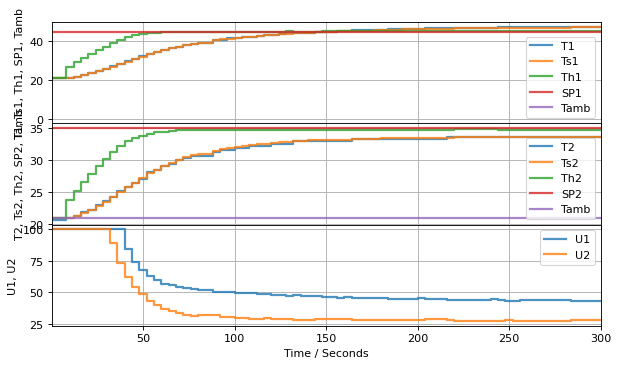

TCLab Model disconnected successfully.


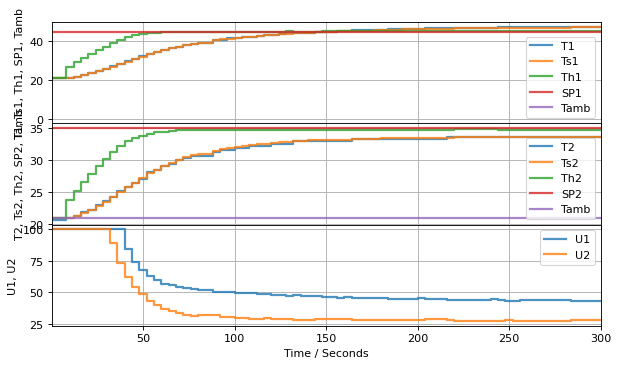

In [138]:
t_final = 300
t_step = 4         # for event loop
control_step = 5   # for controller
alpha_set = 0.01 
SP1 = 45
SP2 = 35

# create a controller instance
controller = my_predictive_control(dt=control_step, alpha=alpha_set)
U1, U2 = next(controller)

# create estimator instance
observer = tclab_observer(L)
Th1, Ts1, Th2, Ts2 = next(observer)

# execute the event loop
TCLab = setup(connected=False, speedup=5)
with TCLab() as lab:
    h = Historian([('SP1', lambda: SP1), 
                   ('SP2', lambda: SP2), 
                   ('T1', lambda: T1), 
                   ('U1', lambda: U1), 
                   ('T2', lambda: T2), 
                   ('U2', lambda: U2), 
                   ('Th1', lambda: Th1), 
                   ('Ts1', lambda: Ts1),
                   ('Th2', lambda: Th2), 
                   ('Ts2', lambda: Ts2),
                   ('Tamb', lambda: Tamb)])
    p = Plotter(h, t_final, layout=[['T1','Ts1','Th1', 'SP1', 'Tamb'], ['T2','Ts2','Th2', 'SP2', 'Tamb'], ['U1','U2']])
    for t in clock(t_final, t_step):
        T1 = lab.T1 
        T2 = lab.T2
        
        # run observer to get Th and Ts
        Th1, Ts1, Th2, Ts2 = observer.send([t, [U1,U2], [T1,T2], Tamb])
        Th = [Th1,Th2]
        Ts = [Ts1,Ts2]
        
        U1, U2 = controller.send([[SP1,SP2], Th, Ts, Tamb])
        
        lab.Q1(U1)
        lab.Q2(U2)
        p.update(t)

### 6.4.7.3 Exercise 3. Putting it all together.

For the final exercise, apply the results of Exercise 2 to your actual device hardware. Run the experiment for at least 600 seconds. How did you do?

### Note: for this part, I will use calculated parameters for my device, as well as the optimal L matrix found in Lab 6.

In [139]:
# construct matrices based on Lab 5 results

# define parameters from Lab 2
CpH = 8.7738
CpS = 2.9110
Ua = 0.0495195
Ub = 0.273355
Uc = 0.0387042

# constant parameters
P1 = 200               # P1 units
P2 = 100               # P2 units
alpha = 0.00016        # watts / (units P1 * percent U1)

# construct arrays
A = np.array([[-(Ua + Ub + Uc)/CpH, Ub/CpH, Uc/CpH, 0], [Ub/CpS, -Ub/CpS, 0, 0],
              [Uc/CpH, 0, -(Ua + Ub + Uc)/CpH, Ub/CpH], [0, 0, Ub/CpS, -Ub/CpS]])  # 4x4
Bu = np.array([[alpha*P1/CpH, 0], [0, 0], [0, alpha*P2/CpH], [0, 0]])     # 4x2
Bd = np.array([[Ua/CpH], [0], [Ua/CpH], [0]])           # 4x1
C = np.array([[0, 1, 0, 0], [0, 0, 0, 1]])                   # 2x4

# print arrays
print('A:')
print(A)
print('Bu:')
print(Bu)
print('Bd:')
print(Bd)
print('C:')
print(C)

A:
[[-0.04121119  0.03115583  0.00441134  0.        ]
 [ 0.09390416 -0.09390416  0.          0.        ]
 [ 0.00441134  0.         -0.04121119  0.03115583]
 [ 0.          0.          0.09390416 -0.09390416]]
Bu:
[[0.00364722 0.        ]
 [0.         0.        ]
 [0.         0.00182361]
 [0.         0.        ]]
Bd:
[[0.00564402]
 [0.        ]
 [0.00564402]
 [0.        ]]
C:
[[0 1 0 0]
 [0 0 0 1]]


In [140]:
from scipy.signal import place_poles

evals, _ = np.linalg.eig(A)

results = place_poles(A.T, C.T, 5*evals)
L = results.gain_matrix.T

print(L)

[[ 0.00335292 -0.0727295 ]
 [ 0.54055245 -0.01764166]
 [-0.0727484   0.00326784]
 [-0.01764791  0.54037029]]


In [142]:
# set ambient temperature
from tclab import TCLab, setup, clock, Historian, Plotter

with TCLab() as lab:
    T1 = lab.T1
    T2 = lab.T2
    Tamb = (T1 + T2) / 2
    print('T_amb:', Tamb)

TCLab version 0.4.9
Arduino Leonardo connected on port COM6 at 115200 baud.
TCLab Firmware 2.0.1 Arduino Leonardo/Micro.
T_amb: 24.766
TCLab disconnected successfully.


### Setting Sensed Temperatures to Set Points

In [143]:
# create controller
def my_predictive_control(t_horizon=300, dt=2, alpha=0):
    # create time grid
    n = round(t_horizon/dt)
    t_grid = np.linspace(0, t_horizon, n+1)
    
    # create decision variables and all parts of the model
    # that do not depend on information from the event loop
    u = {t: cp.Variable(2, nonneg=True) for t in t_grid}
    x = {t: cp.Variable(4) for t in t_grid}
    y = {t: cp.Variable(2) for t in t_grid}
    output = [y[t] == C@x[t] for t in t_grid]
    input1 = [u[t][0] <= 100 for t in t_grid]
    input2 = [u[t][1] <= 100 for t in t_grid]

    MV = [0, 0]
    while True:
        # yield MV, then wait for new information to update MV
        SP, Th, Ts, Tamb = yield MV   # these should now be multivariable arrays
        objective1 = cp.Minimize((1-alpha)*sum((y[t][0]-SP[0])**2 for t in t_grid) +
                                alpha*sum((u[t][0]-u[t-dt][0])**2 for t in t_grid[1:]))
        objective2 = cp.Minimize((1-alpha)*sum((y[t][1]-SP[1])**2 for t in t_grid) +
                                alpha*sum((u[t][1]-u[t-dt][1])**2 for t in t_grid[1:]))
        model = [x[t] == x[t-dt] + dt*(A@x[t-dt] + Bu@u[t-dt] + Bd@[Tamb]) for t in t_grid[1:]]
        IC = [x[0] == [Th[0], Ts[0], Th[1], Ts[1]]]
        problem = cp.Problem(objective1 + objective2,  model + IC + output + input1 + input2)
        problem.solve(warm_start=True)
        MV = [u[0].value[0], u[0].value[1]]

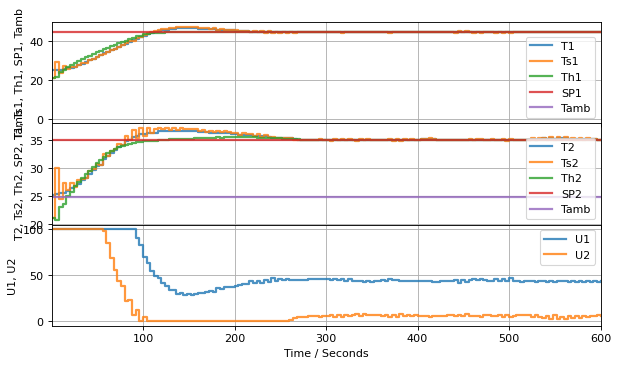

TCLab disconnected successfully.


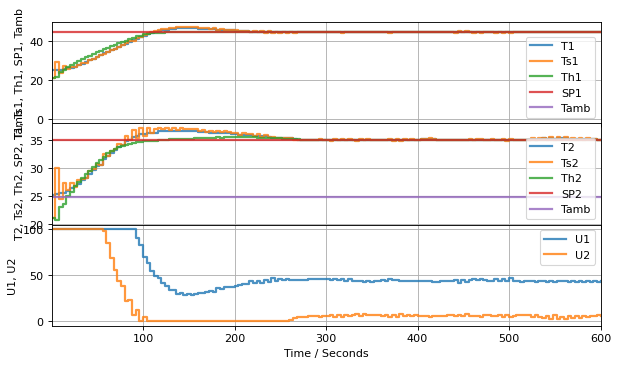

In [148]:
t_final = 600
t_step = 4         # for event loop
control_step = 5   # for controller
alpha_set = 0.01  
SP1 = 45
SP2 = 35

# create a controller instance
controller = my_predictive_control(dt=control_step, alpha=alpha_set)
U1, U2 = next(controller)

# create estimator instance
observer = tclab_observer(L)
Th1, Ts1, Th2, Ts2 = next(observer)

# execute the event loop
from tclab import TCLab, setup, clock, Historian, Plotter
with TCLab() as lab:
    h = Historian([('SP1', lambda: SP1), 
                   ('SP2', lambda: SP2), 
                   ('T1', lambda: T1), 
                   ('U1', lambda: U1), 
                   ('T2', lambda: T2), 
                   ('U2', lambda: U2), 
                   ('Th1', lambda: Th1), 
                   ('Ts1', lambda: Ts1),
                   ('Th2', lambda: Th2), 
                   ('Ts2', lambda: Ts2),
                   ('Tamb', lambda: Tamb)])
    p = Plotter(h, t_final, layout=[['T1','Ts1','Th1', 'SP1', 'Tamb'], ['T2','Ts2','Th2', 'SP2', 'Tamb'], ['U1','U2']])
    for t in clock(t_final, t_step):
        T1 = lab.T1 
        T2 = lab.T2
        
        # run observer to get Th and Ts
        Th1, Ts1, Th2, Ts2 = observer.send([t, [U1,U2], [T1,T2], Tamb])
        Th = [Th1,Th2]
        Ts = [Ts1,Ts2]
        
        U1, U2 = controller.send([[SP1,SP2], Th, Ts, Tamb])
        
        lab.Q1(U1)
        lab.Q2(U2)
        p.update(t)

### Setting Heater Temperatures to Set Points

In [149]:
# create controller
def my_predictive_control(t_horizon=300, dt=2, alpha=0):
    # create time grid
    n = round(t_horizon/dt)
    t_grid = np.linspace(0, t_horizon, n+1)
    
    # create decision variables and all parts of the model
    # that do not depend on information from the event loop
    u = {t: cp.Variable(2, nonneg=True) for t in t_grid}
    x = {t: cp.Variable(4) for t in t_grid}
    y = {t: cp.Variable(2) for t in t_grid}
    output = [y[t] == C@x[t] for t in t_grid]
    input1 = [u[t][0] <= 100 for t in t_grid]
    input2 = [u[t][1] <= 100 for t in t_grid]

    MV = [0, 0]
    while True:
        # yield MV, then wait for new information to update MV
        SP, Th, Ts, Tamb = yield MV   # these should now be multivariable arrays
        objective1 = cp.Minimize((1-alpha)*sum((x[t][0]-SP[0])**2 for t in t_grid) +
                                alpha*sum((u[t][0]-u[t-dt][0])**2 for t in t_grid[1:]))
        objective2 = cp.Minimize((1-alpha)*sum((x[t][2]-SP[1])**2 for t in t_grid) +
                                alpha*sum((u[t][1]-u[t-dt][1])**2 for t in t_grid[1:]))
        model = [x[t] == x[t-dt] + dt*(A@x[t-dt] + Bu@u[t-dt] + Bd@[Tamb]) for t in t_grid[1:]]
        IC = [x[0] == [Th[0], Ts[0], Th[1], Ts[1]]]
        problem = cp.Problem(objective1 + objective2,  model + IC + output + input1 + input2)
        problem.solve(warm_start=True)
        MV = [u[0].value[0], u[0].value[1]]

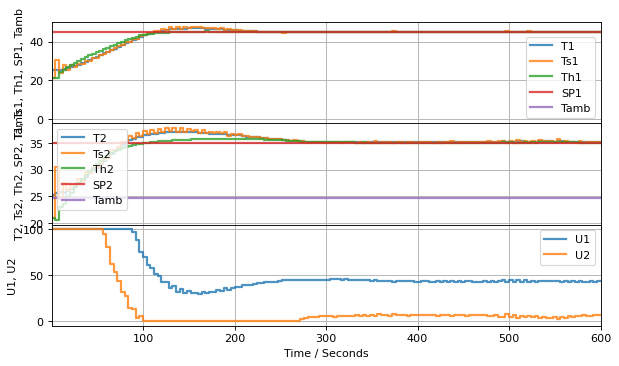

TCLab disconnected successfully.


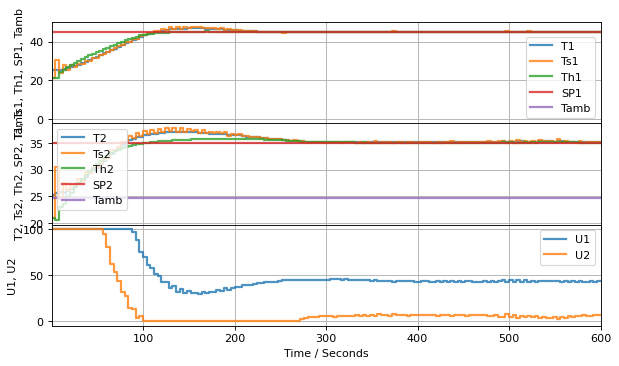

In [150]:
t_final = 600
t_step = 4         # for event loop
control_step = 5   # for controller
alpha_set = 0.01  
SP1 = 45
SP2 = 35

# create a controller instance
controller = my_predictive_control(dt=control_step, alpha=alpha_set)
U1, U2 = next(controller)

# create estimator instance
observer = tclab_observer(L)
Th1, Ts1, Th2, Ts2 = next(observer)

# execute the event loop
from tclab import TCLab, setup, clock, Historian, Plotter
with TCLab() as lab:
    h = Historian([('SP1', lambda: SP1), 
                   ('SP2', lambda: SP2), 
                   ('T1', lambda: T1), 
                   ('U1', lambda: U1), 
                   ('T2', lambda: T2), 
                   ('U2', lambda: U2), 
                   ('Th1', lambda: Th1), 
                   ('Ts1', lambda: Ts1),
                   ('Th2', lambda: Th2), 
                   ('Ts2', lambda: Ts2),
                   ('Tamb', lambda: Tamb)])
    p = Plotter(h, t_final, layout=[['T1','Ts1','Th1', 'SP1', 'Tamb'], ['T2','Ts2','Th2', 'SP2', 'Tamb'], ['U1','U2']])
    for t in clock(t_final, t_step):
        T1 = lab.T1 
        T2 = lab.T2
        
        # run observer to get Th and Ts
        Th1, Ts1, Th2, Ts2 = observer.send([t, [U1,U2], [T1,T2], Tamb])
        Th = [Th1,Th2]
        Ts = [Ts1,Ts2]
        
        U1, U2 = controller.send([[SP1,SP2], Th, Ts, Tamb])
        
        lab.Q1(U1)
        lab.Q2(U2)
        p.update(t)

The control protocol was overall effective, especially at later times. Some oscillation in the early model was observed but quickly died down, and heater 2 overshot its setpoint initially, likely due to effects of heater 1.

### 6.4.7.4 Exercise 4. Do something nice for yourself.

Congratulations on your newly minted expertise! If you got this far, then you have successfully implemented multivariable model predictive control on real hardware. That's an outstanding accomplishment for any engineer, and gives you the conceptual and practical framework to understand many of the contemporary applications of advanced process control.

If you want validation, just Google "Model predictive control of" and add a topic of interest to you. 

<!--NAVIGATION-->
< [6.3  Predictive Control](https://jckantor.github.io/cbe30338-2021/06.03-Predictive-Control.html) | [Contents](toc.html) | [Tag Index](tag_index.html) | [7.0 Projects](https://jckantor.github.io/cbe30338-2021/07.00-Projects.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/06.04-Implementing-Predictive-Control.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/06.04-Implementing-Predictive-Control.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>